In [2]:
# !pip install qiskit qiskit-optimization
# !pip install dwave-ocean-sdk
# !dwave config create # config file created in github codespace
# !pip install pennylane --upgrade
# !pip install pylatexenc

> 1. From Integer Linear Programming (ILP) to Quadratic Unconstrained Binary Optimization (QUBO)
>
>    Define the ILP formulation of the BPP. You can use Docplex or similar frameworks to do it. 

Given $n$ items, each with an associated weight $w_i$, and bins with maximum weight (capacity) $C$. $x_{ij}$ represent decision variables that equals 1 if item $i$ is put into bin $j$, and $y_j$ = 1 if bin $j$ is used. Assume the maximum number of bins equals to number of items $n$. The objective is to minimize the number of bins
$$
\quad \sum_{j=1}^{n} y_j
$$

subject to constraints that 
1. 1 item is assigned and only assigned to 1 bin
$$
\quad \sum_{j=1}^{n} x_{ij} = 1, \quad \forall i = 1, \ldots, n
$$
2. The total weight of items in a bin respects the bin capacity
$$
\quad \sum_{i=1}^{n} w_i x_{ij} \leq C, \quad \forall j = 1, \ldots, n
$$
3. If a bin is not used $y_j = 0$, no items is assigned to it $x_{ij} = 0$ for all i. 
$$
\quad x_{ij} \leq y_j, \quad \forall i = 1, \ldots, n, \forall j = 1, \ldots, n
$$
Note the last two constraints can be combined by changing the right hand side from $C$ to $C y_j$, but it is separated for the ease of following implementations.


In [1]:
from docplex.mp.model import Model

def define_ilp(items_weight: list, bin_capacity: float, verbose = False) -> Model:
    """
    Define an integer linear programming model for the bin packing problem.

    Parameters
    ----------
    items_weight : list of float
        Weights of the items.
    bin_capacity : float
        naximum weight that a bin can hold.
    """
    N = len(items_weight)
    model = Model()
    x = {(i, j): model.binary_var() for i in range(N) for j in range(N)}
    y = [model.binary_var() for j in range(N)]
    # objective
    model.minimize(model.sum(y[j] for j in range(N)))
    # constraints 1, 2, 3
    for i in range(N):
        model.add_constraint(model.sum(x[i, j] for j in range(N)) == 1)
    for j in range(N):
        model.add_constraint(model.sum(items_weight[i] * x[i, j] for i in range(N)) <= bin_capacity)
    for i in range(N):
        for j in range(N):
            model.add_constraint(x[i, j] <= y[j])
    if verbose:
        print(f"Number of variables: {model.number_of_variables} and constraints: {model.number_of_constraints}")
        print(f"Model objective: {model.get_objective_expr()}")
    return model


> Create a function to transform the ILP model into a QUBO 

In QUBO, the objective function is linear with the form $L x$ and quatradic with the form $x^T Q x$, where x is a vector of binary decision variables and Q is a square matrix of constants. As an alternative to ILP constraints, we introduce quadratic penalties as follows: 
1. Converting a equality constraint $a_1 x_1 + a_2 x_2 = b$ to penalty terms takes the form of
- constant $ C += b^2 $
- linear $ L[x_i] -= 2 a_i * b $
- quadratic $ Q[x_i, x_j] += a_i * a_j $

2. Converting an inequality constraint to equality by adding slack variables in a binary expansion. The number of slack variables needed is $log_2(b)$. The equation becomes $(a_1 x_1 + a_2 x_2 + 2^l s_l = b)$, where $s$ is the slack variable with $2^l$ or $b - 2^l$ as the coefficient. 

3. The constraint $x_i \leq x_j$ is special and can be converted to $x_i - x_j x_i$.

In L and Q, the first $n$ rows (and columns) are $x_{ij}$ variables, next $n$ are $y_j$ variables, and the rest are slack variables. Q is usually a upper triangular matrix, so at the end of the calculation, we set $Q = Q + Q^T - diag(Q)$.

For a small system with 2 items with weights 1 and 2 and 2 bins with capacity 3, assuming penalty factor is 1, 
1. the objective function is
$$
Q = x5 + x6
$$
2. Item Assignment Constraint: notice the rhs is 1, coefs = [1, 1]
$$
x1+x2 == 1
$$
$$
P_1 = 1 - 2 x1 - 2 x2 + x1 x2 + x2 x1
$$

3. Bin Capacity Constraint: rhs = 3, number of slack variables = 2, coefs = [1, 2, 1, 2]
$$
x1 + 2 x3 <= 3,
$$
$$
x1 + 2 x3 + s1 + 2 s2 = 3
$$

4. Bin Assignment Constraint:
$$
x1 <= x5, 
P_5 = x1 - x1 x5
$$

In [3]:
import numpy as np
import math

def constraint_to_penalty(num_total_variables: int, item_idx_list: list, penalty_factor: float, rhs: int, coeffs: np.ndarray):
    """
    Convert an equality constraint to penalty terms.
    
    Parameters
    ----------
    num_total_variables : int
        Total number of variables in the QUBO model.
    item_idx_list : list
        List of indices of variables that are involved in the constraint.
    penalty_factor : float
        Penalty factor for the constraint.
    rhs : int
        Right-hand side of the constraint.
    coeffs : np.ndarray
        Coefficients of the variables in the constraint.
    """
    constant = penalty_factor * rhs ** 2
    linear = np.zeros(num_total_variables)
    quadratic = np.zeros((num_total_variables, num_total_variables))
    for item_idx in item_idx_list: # for each bin that item could be placed
        # linear term
        linear[item_idx] -= 2 * penalty_factor * rhs * coeffs[item_idx]
        # quadratic term
        for item_jdx in item_idx_list:
            quadratic[item_idx, item_jdx] += penalty_factor * coeffs[item_idx]* coeffs[item_jdx]
    return constant, linear, quadratic

def define_qubo(items_weight: list, bin_capacity: float, penalty_factor: float = 1.0, verbose = False) -> np.ndarray:
    """
    Define a QUBO model for the bin packing problem.

    Parameters
    ----------
    items_weight : list of float
        Weights of the items.
    bin_capacity : float
        Maximum weight that a bin can hold.
    penalty_factor : float
        Penalty factor for the constraints.
    verbose : bool
        If True, print the number of variables and constraints
    """
    num_item = len(items_weight)
    # construct all variables
    item_variables = (0, num_item ** 2)
    bin_variables = (item_variables[1], item_variables[1] + num_item)
    num_slack_variables_per_eq = math.floor(np.log2(bin_capacity))
    last_slack_coeff = None
    if 2 **num_slack_variables_per_eq - 1 < bin_capacity:
        last_slack_coeff = bin_capacity + 1 - 2 ** (num_slack_variables_per_eq)
        num_slack_variables_per_eq += 1
    slack_variables = (bin_variables[1], bin_variables[1] + num_slack_variables_per_eq * num_item)
    num_total_variables = slack_variables[1]

    constant = 0
    linear = np.zeros(num_total_variables)
    quadratic = np.zeros((num_total_variables, num_total_variables))
    # objective: 
    for i in range(bin_variables[0], bin_variables[1]):
        linear[i] = 1
    # constraints:
    # x1+x2 == 1
    for i in range(0, num_item**2, num_item): # for constraints on each item
        item_idx_list = range(i, num_item + i)
        P1_coeffs = np.ones(num_total_variables)
        Pconstant, Plinear, Pquadratic = constraint_to_penalty(num_total_variables, item_idx_list, penalty_factor, 1, P1_coeffs)
        constant += Pconstant
        linear = np.add(linear, Plinear)
        quadratic = np.add(quadratic, Pquadratic)
        
    # x1 + 2 x3 + s1 + 2 s2 = 3
    # construct the coefficients
    P2_coeffs = np.zeros(num_total_variables)
    for i in range(num_item):
        for j in range(num_item):
            P2_coeffs[i * num_item + j] = items_weight[i]
            
    for i in range(num_item):
        for l in range(num_slack_variables_per_eq):
            if last_slack_coeff is not None and l == num_slack_variables_per_eq - 1:
                P2_coeffs[slack_variables[0] + i * num_slack_variables_per_eq + l] = last_slack_coeff
            else:
                P2_coeffs[slack_variables[0] + i * num_slack_variables_per_eq + l] = 2 ** l
            
    for b in range(0, num_item): # for each bin 
        item_idx_list = range(b, num_item**2, num_item) 
        slack_idx_list = range(slack_variables[0] + b * num_slack_variables_per_eq, slack_variables[0] + (b + 1) * num_slack_variables_per_eq)
        item_idx_list = list(item_idx_list) + list(slack_idx_list)
        Pconstant, Plinear, Pquadratic = constraint_to_penalty(num_total_variables, item_idx_list, penalty_factor, bin_capacity, P2_coeffs)
        constant += Pconstant
        linear = np.add(linear, Plinear)
        quadratic = np.add(quadratic, Pquadratic)
        
    # x1 <= x5, P_5 = x1 - x1 x5
    for b in range(0, num_item): # for each bin 
        bin_idx = bin_variables[0] + b
        for item_idx in range(b, num_item**2, num_item): # for each item that could be placed in the bin
            linear[item_idx] += penalty_factor
            # quadratic term
            quadratic[item_idx, bin_idx] -= penalty_factor
            
    # convert quadratic to upper triangular matrix
    quadratic += quadratic.T - np.diag(quadratic.diagonal())
    quadratic[np.tril_indices(num_total_variables, -1)] = 0
    
    if verbose:
        print(f"Total number of variables: {num_total_variables}, item idx {item_variables}, bin idx {bin_variables}, slack idx {slack_variables}")
        print(f"Offset: {constant}, num of linear terms: {np.count_nonzero(linear)}, num of quadratic terms: {np.count_nonzero(quadratic)}")
    return constant, linear, quadratic

> Test your function with specific instances (size small, medium, and big) 

The number of variables is $n^2 + n + log_2(C)$. For two items and two bins, if capacity is 3, number of slack variables per capacity constraint is 2 and total number of variables is 8. If capacity is 4, number of slack variables is 3, and total number of variables is 10.

I benchmarked my implementation with qiskit's built-in function to convert ILP to QUBO. The results are consistent.

In [4]:
import numpy as np
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

np.random.seed(42)

instances = {
    'small1': {
        'weights': [1, 2], 
        'bin_capacity': 3
    },
    'small2': {
        'weights': [2, 2], 
        'bin_capacity': 4
    },
    'medium': {
        'weights': [1, 2, 1, 2],
        'bin_capacity': 3 # cap the number of slack variables to 2
    },
    'large': {
        'weights': np.random.randint(1, 5, size=8),
        'bin_capacity': 7                     
    }
}
for instance in instances.keys():
    model = define_ilp(instances[instance]['weights'], instances[instance]['bin_capacity'])
    constant, linear, quadratic = define_qubo(instances[instance]['weights'], instances[instance]['bin_capacity'], penalty_factor=3.0, verbose=True)
    test_qp = from_docplex_mp(model)
    conv = QuadraticProgramToQubo(penalty=3.0)
    test_qubo = conv.convert(test_qp)
    test_constant = test_qubo.objective.constant
    test_linear = test_qubo.objective.linear.to_array() 
    test_quadratic = test_qubo.objective.quadratic.to_array()
    if np.isclose(constant, test_constant) and np.allclose(linear, test_linear) and np.allclose(quadratic, test_quadratic):
        print(f"{instance} instance: PASSED")
    else:
        print(f"{instance} instance: FAILED")
        print(f"constant error: {np.abs(constant - test_constant)}")
        print(f"linear error: {np.abs(linear - test_linear)}")
        print(f"quadratic error: {np.abs(quadratic - test_quadratic)}")

Total number of variables: 10, item idx (0, 4), bin idx (4, 6), slack idx (6, 10)
Offset: 60.0, num of linear terms: 10, num of quadratic terms: 26
small1 instance: PASSED
Total number of variables: 12, item idx (0, 4), bin idx (4, 6), slack idx (6, 12)
Offset: 102.0, num of linear terms: 12, num of quadratic terms: 36
small2 instance: PASSED
Total number of variables: 28, item idx (0, 16), bin idx (16, 20), slack idx (20, 28)
Offset: 120.0, num of linear terms: 28, num of quadratic terms: 124
medium instance: PASSED
Total number of variables: 96, item idx (0, 64), bin idx (64, 72), slack idx (72, 96)
Offset: 1200.0, num of linear terms: 96, num of quadratic terms: 816
large instance: PASSED


> 2. Create a Brute Force solver for the QUBO problem and solve the specific instances. 

Following the steps:
1. Generate all $2^n$ possible solutions
2. Evaluate the objective function (energy) by $ x^T Q x + L x$
3. Track the best solution

For the 4 item instance, the number of variables is 28, and the number of possible solutions is $2^{28} = 2.7 × 10^8$. Brute Force solver's time complexity is $O(2^n)$, so it's not feasible for large problems.
I benchmark the results of brute-force solver with numpy minimum eigensolver

In [8]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

def qubo_brute_force(offset: float, linear: np.ndarray, quadratic: np.ndarray):
    """
    Solve the QUBO model by brute force.
    
    Parameters
    ----------
    offset : float
        Constant offset in the QUBO model.
    linear : np.ndarray
        Linear coefficients in the QUBO model.
    quadratic : np.ndarray
        Quadratic coefficients in the QUBO model.
    """
    from itertools import product
    num_vars = len(linear)
    min_energy = float('inf')
    min_state = None
    for state in product([0, 1], repeat=num_vars):
        energy = np.dot(linear, state)
        energy += np.dot(state, np.dot(quadratic, state))
        if energy < min_energy:
            min_energy = energy
            min_state = state
    return min_state, min_energy + offset

for instance in ['small1', 'small2']:
    model = define_ilp(instances[instance]['weights'], instances[instance]['bin_capacity'])
    offset, linear, quadratic = define_qubo(instances[instance]['weights'], instances[instance]['bin_capacity'])
    min_state, min_energy = qubo_brute_force(offset, linear, quadratic)
    print(f"{instance}: the best state is {min_state} with energy {min_energy}")
    
    # test with numpy minimum eigensolver
    model = define_ilp(instances[instance]['weights'], instances[instance]['bin_capacity'])
    test_qp = from_docplex_mp(model)
    conv = QuadraticProgramToQubo(penalty=3.0)
    test_qubo = conv.convert(test_qp)
    exact_mes = NumPyMinimumEigensolver()
    exact = MinimumEigenOptimizer(exact_mes)
    exact_result = exact.solve(test_qubo)
    print(exact_result.prettyprint())

small1: the best state is (0, 1, 0, 1, 0, 1, 1, 1, 0, 0) with energy 1.0
objective function value: 1.0
variable values: x0=0.0, x1=1.0, x2=0.0, x3=1.0, x4=0.0, x5=1.0, c2@int_slack@0=1.0, c2@int_slack@1=1.0, c3@int_slack@0=0.0, c3@int_slack@1=0.0
status: SUCCESS
small2: the best state is (0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0) with energy 1.0
objective function value: 1.0
variable values: x0=0.0, x1=1.0, x2=0.0, x3=1.0, x4=0.0, x5=1.0, c2@int_slack@0=1.0, c2@int_slack@1=1.0, c2@int_slack@2=1.0, c3@int_slack@0=0.0, c3@int_slack@1=0.0, c3@int_slack@2=0.0
status: SUCCESS


> 3. To solve the QUBO, use quantum annealing simulators. You can use the Dwave Ocean Framework.

Following the steps:
1. convert the QUBO to a BinaryQuadraticModel in dimod
2. solve the BQM with DWaveSampler

In [9]:
from dwave.system import DWaveSampler, EmbeddingComposite
from collections import defaultdict
import dimod

def list_to_dict(linear: np.ndarray, quadratic: np.ndarray):
    """
    Convert the linear and quadratic terms to dictionaries.
    """
    linear_dict = {i: linear[i] for i in range(len(linear))}
    quadratic_dict = defaultdict(int)
    for i in range(len(quadratic)):
        linear_dict[i] = linear_dict.get(i, 0) + quadratic[i, i]
        for j in range(i+1, len(quadratic)):
            quadratic_dict[(i, j)] = quadratic_dict.get((i, j), 0) + quadratic[i, j]
    return linear_dict, quadratic_dict

def quantum_annealing_qubo(offset, linear, quadratic):
    """
    Solve the QUBO model by quantum annealing.
    """
    linear_dict, quadratic_dict = list_to_dict(linear, quadratic)
    bqm = dimod.BinaryQuadraticModel(linear_dict, quadratic_dict, offset, vartype=dimod.BINARY)
    sampler = EmbeddingComposite(DWaveSampler()) 
    sampleset = sampler.sample(bqm, num_reads = 100)
    best_solution = sampleset.first.sample
    best_energy = sampleset.first.energy
    return best_solution, best_energy

for instance in ['small1', 'small2']:
    offset, linear, quadratic = define_qubo(instances[instance]['weights'], instances[instance]['bin_capacity'])
    best_solution, best_energy = quantum_annealing_qubo(offset, linear, quadratic)
    solution_list = [0] * (max(best_solution.keys()) + 1)
    for key, value in best_solution.items():
        solution_list[key] = int(value)
    print(f"best solution: {solution_list} with energy {best_energy}")

best solution: [1, 0, 1, 0, 1, 0, 0, 0, 1, 1] with energy 1.0
best solution: [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1] with energy 1.0


> 4. Use a Quantum Variational approach to solve the QUBO. 
>
>   Create multiple Ansantz for tests. 

Ideally, the created ansantz should have minimal number of entangling operations, quantum gates, and optimazation parameters, but it also needs to efficiently sample the Hilbert space and capture important correlations between the qubits. I try the following ansatzes:
1. linear entangled ansatze where each qubit shared control Z gates with its nearestneighbor qubits.
2. problem-specific ansatze with entanglement structure that mimics the relationship between item, bin and slack variables.
3. hardware-efficient ansatze with layers of single-qubit operations spanning SU(2) and CX entanglements.

Each layer is formed by =rotation gates, such as RX or 
CRZ, and entanglement gates like Toffoli gates or CX. The rotation gates are parameterized.

>   Build a function with input being the QUBO and Ansantz. Using a hybrid approach solved the QUBO. 

1. The cost function $C(\theta)$ is the expectation value of the Hamiltonian $\hat{H}$ with respect to a given configuration $|\psi>$. This is calculated using `Estimator` in Qiskit. Here, the Hamiltonian is translated from QUBO matrix using the `to_ising` method.

2. In the optimization loop, an optimizer iteratively uses cost function evaluations to select the next set of parameters, and repeats the process until it reaches a stable state. We can use local optimizers like SLSQP, or global optimizers like BFGS and COBYLA.

3. After the optimization, we can use the optimized parameters to construct the final circuit and sample the state to get the final result.

In [11]:
model = define_ilp(instances['small1']['weights'], instances["small1"]['bin_capacity'])
test_qp = from_docplex_mp(model)
conv = QuadraticProgramToQubo(penalty=3.0)
test_qubo = conv.convert(test_qp)
observable, offset = test_qubo.to_ising()
print(f"Hamiltonian: {observable}")
print("Offset: {}".format(offset))
num_qubits = observable.num_qubits

Hamiltonian: SparsePauliOp(['IIIIIZIIII', 'IIIIZIIIII', 'IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIZIIIZ', 'IIIZIIIIIZ', 'IIZIIIIIIZ', 'IIIIIIZIZI', 'IIIIZIIIZI', 'IZIIIIIIZI', 'ZIIIIIIIZI', 'IIIIIIZZII', 'IIIIIZIZII', 'IIIZIIIZII', 'IIZIIIIZII', 'IIIIZIZIII', 'IZIIIIZIII', 'ZIIIIIZIII', 'IIZZIIIIII', 'ZZIIIIIIII'],
              coeffs=[ 1.  +0.j,  1.  +0.j, -0.75+0.j, -0.75+0.j, -0.75+0.j, -0.75+0.j,
  1.5 +0.j,  3.  +0.j, -0.75+0.j,  1.5 +0.j,  3.  +0.j,  3.  +0.j,
 -0.75+0.j,  1.5 +0.j,  3.  +0.j,  1.5 +0.j, -0.75+0.j,  3.  +0.j,
  6.  +0.j, -0.75+0.j,  3.  +0.j,  6.  +0.j,  3.  +0.j,  3.  +0.j])
offset: 22.0


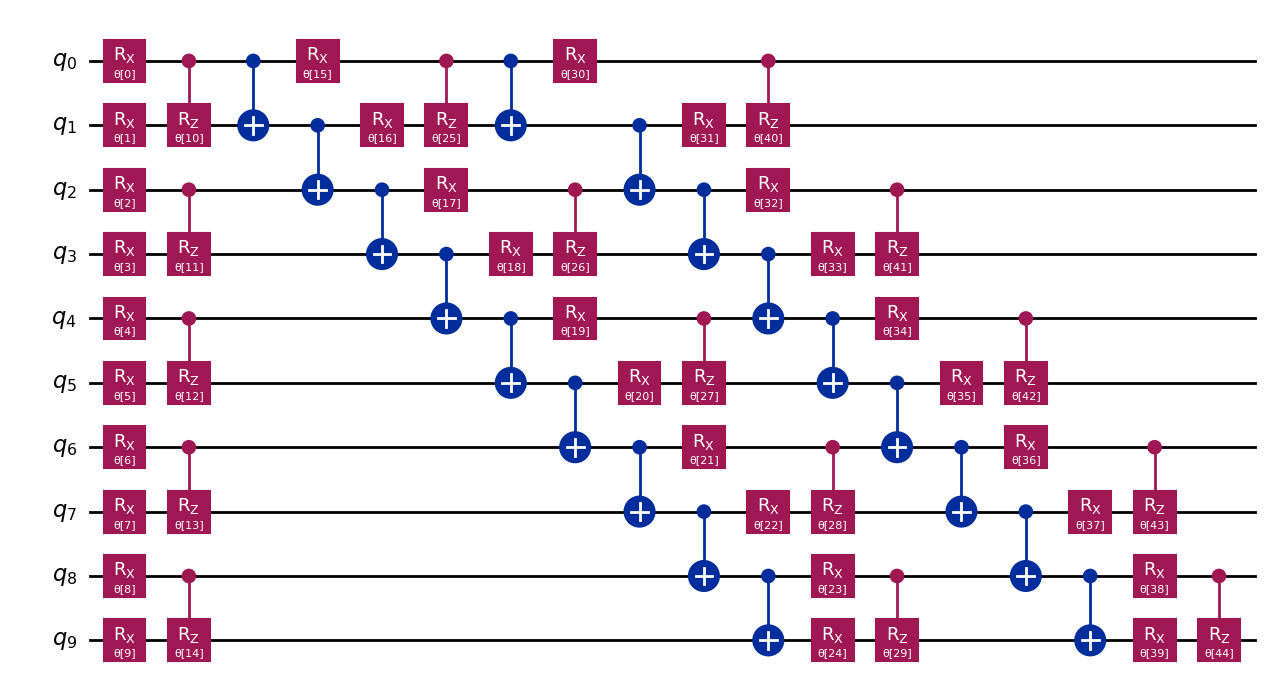

In [13]:
from qiskit.circuit.library import TwoLocal, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter("θ")
# linear entangled ansatze
linear_entangle_ansatz = TwoLocal(
    num_qubits=num_qubits,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
)
linear_entangle_ansatz.decompose().draw("mpl")

I manually chose a list of qubits to entangle because:
1. qubit 0 and 2 represent items for first bin (qubit 4), 1 and 3 represent items for the second bin (qubit 5)
2. qubit 6 and 7 represent the slack variables for the first bin, 8 and 9 represent the slack variables for the second bin
3. qubit 0 and 1 represent item 1; qubit 2, 3 represents item 2.
I use controlled Z gates to entangle the qubits, which flips the phase of the target qubit if the control qubit is in the ∣1⟩ state.

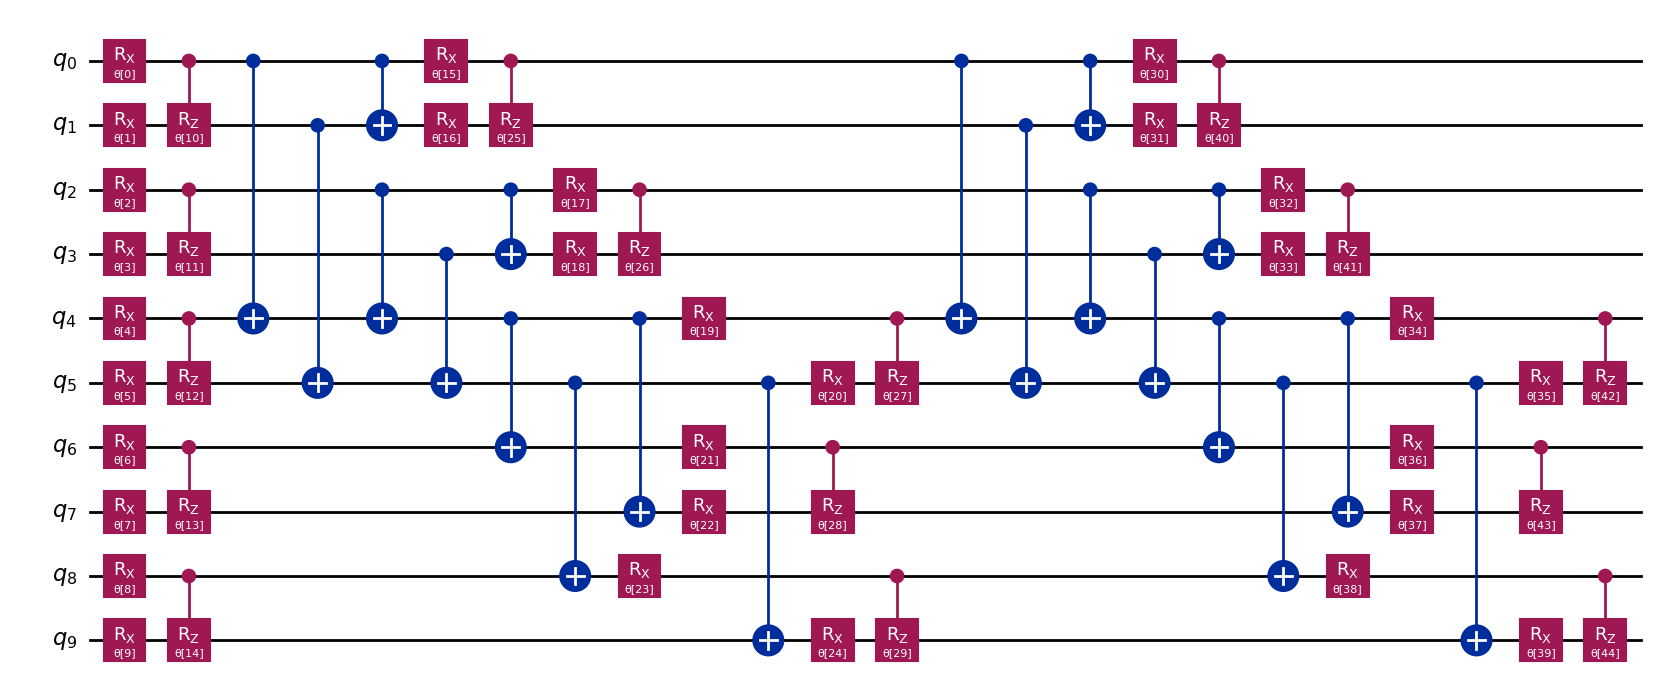

In [14]:
entangler_map = [[0, 4], [2, 4], [1, 5], [3, 5], [4, 6], [4, 7], [5, 8], [5, 9], [0, 1], [2, 3]]
 
designed_entangle_ansatz = TwoLocal(
    num_qubits=num_qubits,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks="cz",
    entanglement=entangler_map,
    reps=2,
)
designed_entangle_ansatz.decompose().draw("mpl")

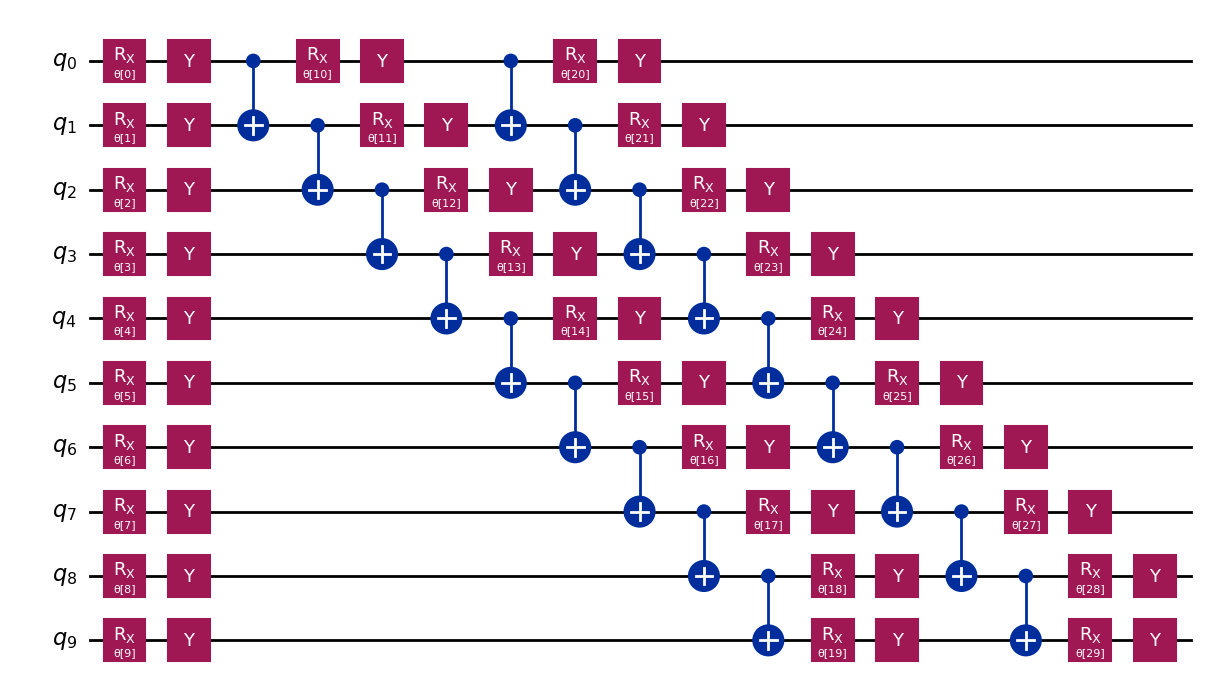

In [15]:

from qiskit.circuit.library import EfficientSU2

EfficientSU2_ansatz = EfficientSU2(num_qubits, su2_gates=["rx", "y"], entanglement="linear", reps=2)
EfficientSU2_ansatz.decompose().draw("mpl")


In [16]:
from qiskit.primitives import StatevectorEstimator
import numpy as np
from scipy.optimize import minimize

def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return expected value of Hamiltonian for given parametrized ansatz 

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    estimator_job = estimator.run([(ansatz, hamiltonian, [params])])
    estimator_result = estimator_job.result()[0]
    cost = estimator_result.data.evs[0]
    return cost

def run_vqe(ansatz, hamiltonian, estimator):
    """Run VQE algorithm to find optimal parameters for the ansatz

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        
    Returns:
        tuple: Optimized parameters and energy estimate
    """
    num_params = ansatz.num_parameters
    initial_params = np.random.rand(num_params)
    result = minimize(cost_func_vqe, initial_params, args=(ansatz, hamiltonian, estimator), method="BFGS")
    return result

Linear Entangled optimized energy: 16.50000000002956
Designed Entangled optimized energy: 16.000000000010644
Hardware Efficient optimized energy: 14.000000000038483


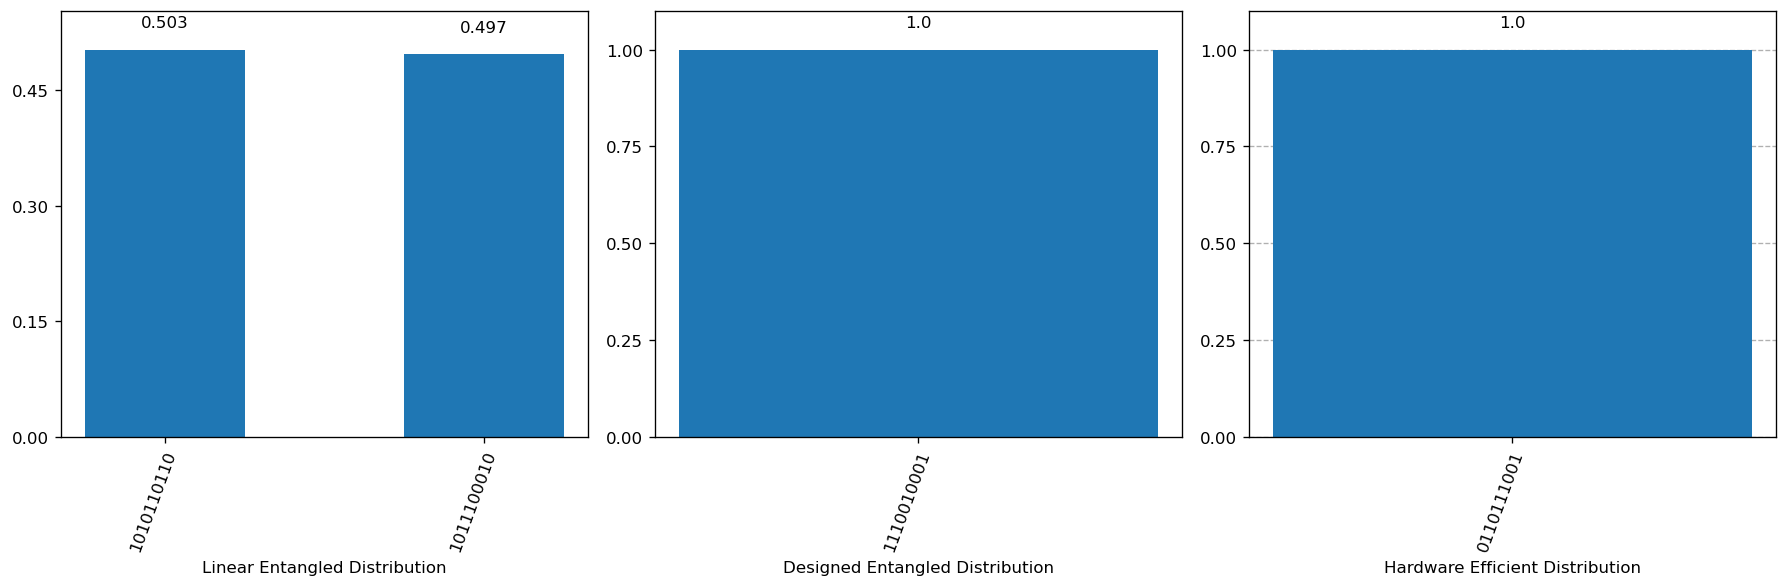

In [19]:
from qiskit.primitives import StatevectorSampler
from matplotlib import pyplot as plt
from qiskit.visualization import plot_distribution

estimator = StatevectorEstimator()
sampler = StatevectorSampler()

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=120)
ansatz_names = ["Linear Entangled", "Designed Entangled", "Hardware Efficient"]

for idx, (ansatz, name) in enumerate(zip([linear_entangle_ansatz, designed_entangle_ansatz, EfficientSU2_ansatz], ansatz_names)):
    # run VQE
    result = run_vqe(ansatz, observable, estimator)
    print(f"{name} optimized energy: {cost_func_vqe(result.x, ansatz, observable, estimator) + offset}")
    
    # run circuit with optimized parameters
    qc = ansatz.assign_parameters(result.x)
    qc.measure_all()
    job = sampler.run([qc], shots = 1024)
    data_pub = job.result()[0].data.meas.get_counts()
    plot_distribution(data_pub, ax=ax[idx])
    ax[idx].set_ylabel("")  # Remove y-axis label
    ax[idx].set_xlabel(f"{name} Distribution")
plt.tight_layout()
plt.show()

> 5. Use QAOA to solve the QUBO. 
>
> Create from scratch a QAOA function. 
QAOA is composed of:
1. Preparing qubits in an equal superposition over all possible states by Hadamard gates
2. In each run of circuit:
    1. In each layer 
        1. Apply the problem Hamiltonian to evolve the quantum state, making states with higher costs less favorable
        2. Apply the mixer Hamiltonian to explore the solution space. The Pauli-X operator is applied to flip the qubits, helping the algorithm to explore different bitstrings (configurations).
    2. Measure the quantum state to get a candidate solution
    3. Optimize parameters to minimize the cost function.

The cost Hamiltonian is obtained from the QUBO formulation
$$
H_c(\mathrm{z}) = \sum_{i, j > i}^{n} J_{ij} z_i z_j + \sum_{i=1}^n h_{i}z_i + O
$$
and translated into a parametric unitary gate given by
$$
U(H_c, \gamma_i)=e^{-i \gamma_i H_c},\tag{11} = e^{-i \gamma_i \left( \sum_{i<j}^{n-1} J_{ij}Z_iZ_j + \sum_{i}^{n-1} h_iZ_i\right)}
$$
where $\gamma_i$ is a parameter to be optimized. The term $e^{-i \gamma_i J_{ij}Z_iZ_j}$ is implemented by $RZZ(2 \gamma_i J_{ij})$, and $e^{-i \gamma_i h_iZ_i}$ is implemented by $RZ(2 \gamma_i h_i)$.
The mixer Hamiltonian $H_m(X)$ is a parametric unitary gate given by
$$
U(B, \beta_i)=e^{i \beta_i X},\tag{12}
$$
where $\beta_i$ is a parameter to be optimized. The term $e^{i \beta_i X}$ is implemented by $RX(2 \beta_i)$.

We repeat this sequence of gates p times. Note: as p increases, the quality of the approximation improves. We also change the $x_i\in \{0, 1\}$ variables to spin variables $z_i\in \{-1, 1\}$ by the transformation $x_i = (1 - z_i)/2$.

In each run, C is the average energy among all samples. Note: in the spirit of the conditional Value at risk (CVaR) method, we can also take the average over a fixed percentage of the lowest sampled configurations.

In [18]:
def bin_packing_cost(config, linear, quadratic, offset):
    """Compute the cost of a given configuration
    
    Parameters:
        config (list): Binary configuration
        linear (dict): Linear coefficients
        quadratic (dict): Quadratic coefficients
        offset (float): Constant offset
    """
    energy = offset
    for k, v in linear.items():
        energy += v * config[k]
    for k, v in quadratic.items():
        energy += v * config[k[0]] * config[k[1]]
    return energy

# test the cost function with solution from brute force solver
offset, linear, quadratic = define_qubo(instances['small2']['weights'], instances['small2']['bin_capacity'])
linear_dict, quadratic_dict = list_to_dict(linear, quadratic)
solution =  [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]
bin_packing_cost(solution, linear_dict, quadratic_dict, offset)

1.0

In [22]:
import pennylane as qml

shots = 500  # Number of samples used
dev = qml.device("default.qubit", shots=shots)
@qml.qnode(dev)
def qaoa_circuit(gammas, betas, p, h, J, num_qubits):
    """The QAOA circuit to solve the bin packing problem
    Parameters:
    ----------
    gammas : list
        Angles parameters for the cost Hamiltonian
    betas : list
        Angles parameters for the mixer Hamiltonian
    p : int
        Number of layers in the circuit
    h : dict
        Single-qubit terms in the cost Hamiltonian
    J : dict
        Two-qubit terms in the cost Hamiltonian
    num_qubits : int
        Number of qubits in the circuit
        
    Returns:
    -------
    samples : list
        The samples from the circuit
    """
    # Apply the initial layer of Hadamard gates to all qubits
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
    # repeat p layers the circuit
    for layer in range(p):
        # ---------- COST HAMILTONIAN ----------
        for ki, v in h.items():  # single-qubit terms
            qml.RZ(2 * gammas[layer] * v, wires=ki)
        for kij, vij in J.items():  # two-qubit terms
            qml.CNOT(wires=[kij[0], kij[1]])
            qml.RZ(2 * gammas[layer] * vij, wires=kij[1])
            qml.CNOT(wires=[kij[0], kij[1]])
        # ---------- MIXER HAMILTONIAN ----------
        for i in range(num_qubits):
            qml.RX(-2 * betas[layer], wires=i)
    return qml.sample()

# initialize the parameters
p = 10
betas = np.random.uniform(0, np.pi, p)
gammas = np.random.uniform(0, np.pi, p)
# use the smallest instance
offset, linear, quadratic = define_qubo(instances['small1']['weights'], instances['small1']['bin_capacity'])
linear_dict, quadratic_dict = list_to_dict(linear, quadratic)
n_qubits = len(linear)
# draw the circuit
print(qml.draw(qaoa_circuit)(gammas, betas, p, linear_dict, quadratic_dict, n_qubits))

0: ──H──RZ(-22.05)─╭●───────────╭●─╭●────────────╭●─╭●───────────╭●─╭●────────────╭●─╭●───────────╭●
1: ──H──RZ(-22.05)─╰X──RZ(8.82)─╰X─│─────────────│──│────────────│──│─────────────│──│────────────│─
2: ──H──RZ(-35.28)─────────────────╰X──RZ(17.64)─╰X─│────────────│──│─────────────│──│────────────│─
3: ──H──RZ(-35.28)──────────────────────────────────╰X──RZ(0.00)─╰X─│─────────────│──│────────────│─
4: ──H──RZ(4.41)────────────────────────────────────────────────────╰X──RZ(-4.41)─╰X─│────────────│─
5: ──H──RZ(4.41)─────────────────────────────────────────────────────────────────────╰X──RZ(0.00)─╰X
6: ──H──RZ(-22.05)──────────────────────────────────────────────────────────────────────────────────
7: ──H──RZ(-35.28)──────────────────────────────────────────────────────────────────────────────────
8: ──H──RZ(-22.05)──────────────────────────────────────────────────────────────────────────────────
9: ──H──RZ(-35.28)─────────────────────────────────────────────────────────────────────────

uses the classical optimizer COBYLA to iteratively update gammas and betas, aiming to minimize a cost function that evaluates the QAOA circuit’s effectiveness in solving the bin-packing problem. 

In [ ]:
from scipy.optimize import minimize

def evaluate_samples(samples, linear, quadratic, offset = 0):
    """Evaluate average energy of samples
    
    Parameters:
    ----------
    samples : list
        List of samples from the circuit
    linear : dict
        Linear coefficients
    quadratic : dict
        Quadratic coefficients
    offset : float
        Constant offset
        
    Returns:
    -------
    results : dict
        Dictionary of samples and their counts
    energies : dict
        Dictionary of energies and their counts
    avg_energy : float
        Average energy of the samples
    """
    
    results = {}
    for sample in samples:
        result_str = "".join(str(i) for i in sample)
        results[result_str] = results.get(result_str, 0) + 1
        
    energies = {}
    total_energy = 0
    for sample, count in results.items():
        energy = bin_packing_cost([int(i) for i in list(sample)], linear, quadratic, offset)
        energies[energy] = energies.get(energy, 0) + count
        total_energy += energy * count
    avg_energy = total_energy / len(samples)
    return results, energies, avg_energy

def qubo_objective(p, h, J, num_qubits, circuit):
    """Objective function to minimize using the QAOA parameters
    
    Parameters:
    ----------
    p : int
        Number of layers in the circuit 
    h : dict
        Single-qubit terms in the cost Hamiltonian
    J : dict
        Two-qubit terms in the cost Hamiltonian
    num_qubits : int
        Number of qubits in the circuit
    circuit : function
        The QAOA circuit
        
    Returns:
    -------
    f : function
        Objective function to minimize
    """
    
    def f(params):
        gammas = params[:p]
        betas = params[p:]
        samples = circuit(gammas, betas, p, h, J, num_qubits)
        _, _, avg_energy = evaluate_samples(samples, h, J)
        return avg_energy

    return f

# initialize the objective function
params = np.concatenate([gammas, betas])
obj = qubo_objective(p, linear_dict, quadratic_dict, n_qubits, qaoa_circuit)

# run the circuit with random parameters and store the results
first_samples = qaoa_circuit(gammas, betas, p, linear_dict, quadratic_dict, n_qubits)
first_results, first_energies, first_avg_energy = evaluate_samples(first_samples, linear_dict, quadratic_dict, offset)
print(f"Initial energy: {first_avg_energy}")

# Run optimization
opt_result = minimize(obj, params, method="COBYLA",  options = {'disp': True, 'maxiter': 2000})

# Extract the optimized parameters
opt_gammas = opt_result.x[:p]
opt_betas = opt_result.x[p:]

# Run QAOA circuit with optimized angles
final_samples = qaoa_circuit(opt_gammas, opt_betas, p, linear_dict, quadratic_dict, n_qubits)
final_results, final_energies, final_avg_energy = evaluate_samples(final_samples, linear_dict, quadratic_dict, offset)
print(f"Final energy: {final_avg_energy}")

Initial energy: 8.06

   Normal return from subroutine COBYLA

   NFVALS =  176   F =-1.379000E+01    MAXCV = 0.000000E+00
   X = 1.482975E+00   7.916168E-01   1.755494E+00   3.233470E+00   2.080523E+00
       1.058148E+00   2.828945E+00   2.326161E+00   1.743853E+00   2.919017E+00
       2.603887E+00   7.809589E-01   1.504260E+00   2.562726E-01  -1.712464E-02
       3.024543E+00   2.634629E+00   2.204063E+00   1.259912E+00   5.454075E-01
Final energy: 6.394


/tmp/ipykernel_124127/2114165651.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


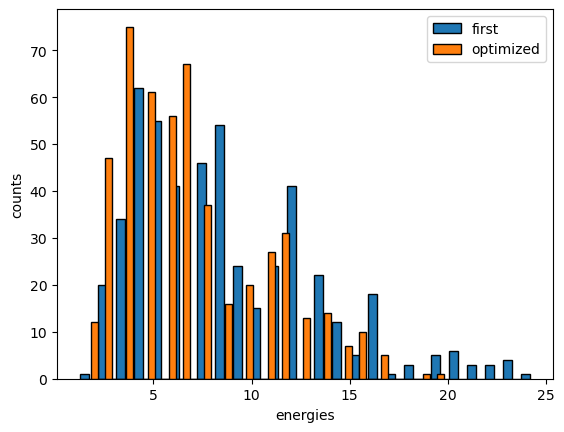

In [25]:
import matplotlib.pyplot as plt

# Plot the energy distribution to see the improvement
fig, ax = plt.subplots()
ax.hist(
    first_energies.keys(),
    weights=first_energies.values(),
    bins=50,
    edgecolor="black",
    label="first",
    align="right",
)
ax.hist(
    final_energies.keys(),
    weights=final_energies.values(),
    bins=50,
    edgecolor="black",
    label="optimized",
    align="left",
)
ax.legend()
ax.set_ylabel("counts")
ax.set_xlabel("energies")
fig.show()
    


 > 6. Compare and analyze the results. 
 
 The optimized circuit gives more samples with low energy.

 
 time-to-solution (TTS). The TTS means a time
that is needed to a heuristic algorithm to find the solution
(ground state energy) with 99% success probability. It is
given by
TTS = taR99,

What is the difference between QAOA, Quantum Annealing, and Quantum Variational approaches with different Ansatz? 

The QUBO model has emerged as an underpinning of the quantum computing area known as quantum annealing and Fujitsu's digital annealing, and has become a subject of study in neuromorphic computing.

QVE variational optimization of a quantum circuit to minimize the expectation value of a given Hamiltonian. The optimization is performed iteratively, with the quantum circuit parameters updated at each step until the most optimal solution is determined. 

QAOA, on the other hand, is a quantum algorithm that prepares a quantum state that is a superposition of all possible solutions to the problem. The algorithm applies a sequence of unitary operations to the initial state, with the number of operations and their parameters being determined by the problem the QAOA algorithm has been designed to solve.

VQE is better suited for problems that require a high degree of precision, while QAOA is better suited for problems with a large array of initial possibilities. VQE is known to be more efficient than QAOA for problems with a lower variety of initial solutions, as it can converge to the optimal solution faster. However, for problems with a higher variety of initial solutions, VQE may become computationally expensive due to the exponential growth of the required resources. QAOA, on the other hand, is designed to handle problems with a large search space efficiently.

How do the results compare with the brute force approach? 

All tasks were grouped by fuel elements quantity for
demonstrating results (see Fig. 1). We note that the DWave annealer shows good result in problem solving in
the small-size cases (2 possible canisters and 2 elements),
while optimal solution was not found for 6 and more elements problem. The standard deviation of TTS is significantly increase with elements quantity for all methods.
This is caused by an exponential growth of the space of
possible solutions, leading to a decrease in the probability
of finding the optimal solution. As a result, the annealing
process often terminates at a suboptimal point instead
of the ground state. This is especially true for complex
problems that require a large number of variables to be
taken into consideration.


## References
1. Quantum Bridge Analytics I: A Tutorial on Formulating and Using QUBO Models https://arxiv.org/pdf/1811.11538
2. A Quantum Approximate Optimization Algorithm https://arxiv.org/pdf/1411.4028
3. Variational quantum algorithms https://arxiv.org/pdf/2012.09265
4. Quantum variational optimization: The role of entanglement and problem hardness https://arxiv.org/pdf/2103.14479
4. Quantum and quantum-inspired optimization for solving the minimum bin packing problem https://arxiv.org/pdf/2301.11265

Tutorials:
1. Converters for Quadratic Programs https://github.com/qiskit-community/qiskit-optimization/blob/807d48167caf11cd93bec85f26b34614fb7868da/docs/tutorials/02_converters_for_quadratic_programs.ipynb#L16
2. Solving Problems with Quantum Samplers https://docs.dwavesys.com/docs/latest/c_gs_3.html
2. Quadratic Unconstrained Binary Optimization (QUBO) https://pennylane.ai/qml/demos/tutorial_QUBO/
3. Ansatze and Variational Forms https://learning.quantum.ibm.com/course/variational-algorithm-design/ansatze-and-variational-forms
3. Comparing VQE and QAOA: Two Quantum Algorithms for Optimization Problems https://www.quantumgrad.com/article/700
4. https://openqaoa.entropicalabs.com/what-is-the-qaoa/